### Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use("ggplot")

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Dataset and Radomization

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess the data

In [3]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    preprocessed_features = selected_features.copy()
    preprocessed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / 
                                                 california_housing_dataframe["population"])
    return preprocessed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = california_housing_dataframe["median_house_value"] / 1000.0
    return output_targets

### Training set and Validation set

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training Examples Summary: ")
display.display(training_examples.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Validation Targets Summary: ")
display.display(validation_targets.describe())

Training Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2633.0,537.9,1423.2,499.4,3.9,2.0
std,2.1,2.0,12.6,2169.2,420.2,1145.0,383.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,296.0,789.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2122.0,432.0,1160.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3136.0,645.0,1710.0,601.2,4.8,2.3
max,42.0,-114.3,52.0,32054.0,5290.0,35682.0,5050.0,15.0,55.2


Validation Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2669.2,543.1,1444.9,505.6,3.9,2.0
std,2.1,2.0,12.5,2205.6,424.6,1154.7,388.1,1.9,1.1
min,32.5,-124.3,1.0,11.0,4.0,9.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1451.8,297.8,791.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2149.0,437.0,1185.0,413.5,3.5,1.9
75%,37.7,-118.0,37.0,3184.0,656.0,1746.2,611.0,4.7,2.3
max,42.0,-114.6,52.0,37937.0,6445.0,28566.0,6082.0,15.0,41.3


Training Targets Summary: 


,median_house_value
count,12000.0
mean,208.1
std,117.0
min,15.0
25%,119.3
50%,180.4
75%,266.5
max,500.0


Validation Targets Summary: 


,median_house_value
count,5000.0
mean,205.4
std,113.4
min,15.0
25%,119.8
50%,180.4
75%,262.2
max,500.0


### Construct Feature Columns

In [5]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_features) for my_features in input_features])

### Input Function

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### FTRL Optimization Algorithm (Follow-the-Regularized-Leader)

In [7]:
def train_model(learning_rate,
                steps,
                batch_size,
                feature_columns,
                training_examples,
                training_targets,
                validation_examples,
                validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create linear_regressor and configure the same
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = feature_columns,
        optimizer = my_optimizer
    )
    
    # Compute input functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the model in a loop
    print("Training model...")
    print("  RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,
                                                                                training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,
                                                                                       validation_targets))
                
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_root_mean_squared_error,
                                                  validation_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
        
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("RMSE vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training", color="magenta")
    plt.plot(validation_rmse, label="validation", color="g")
    plt.legend()
    return linear_regressor

Training model...
  RMSE (on training data): 
    Period 01 : 157.99	159.25
    Period 02 : 124.75	123.77
    Period 03 : 153.79	154.80
    Period 04 : 145.41	146.04
    Period 05 : 137.55	137.89
    Period 06 : 119.25	117.93
    Period 07 : 127.38	126.98
    Period 08 : 134.16	134.52
    Period 09 : 129.54	129.30
    Period 10 : 124.03	123.18
Model training finished.


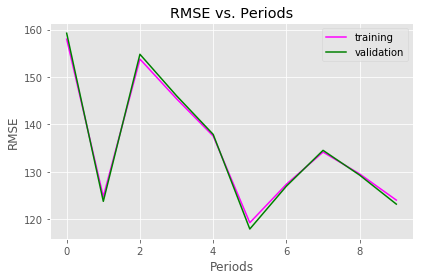

In [8]:
_ = train_model(
    learning_rate = 1.0,
    steps = 500,
    batch_size = 100,
    feature_columns = construct_feature_columns(training_examples),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

### Bucketization based on Quantiles

#### Few Examples

In [9]:
# This function calculates boundaries based on qunatiles,
# so that each bucket contains an equal number of elements.
def get_qunatile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

# examples
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
    households,boundaries=get_qunatile_based_boundaries(
        california_housing_dataframe["households"], 7))
total_rooms = tf.feature_column.numeric_column("total_rooms")
bucketized_total_rooms = tf.feature_column.bucketized_column(
    total_rooms,boundaries=get_qunatile_based_boundaries(
        california_housing_dataframe["total_rooms"], 10))

### Construct Bucketized Feature Columns

In [10]:
def construct_bucketized_feature_columns():
    latitude = tf.feature_column.numeric_column("latitude")
    longitude = tf.feature_column.numeric_column("longitude")
    households = tf.feature_column.numeric_column("households")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    # Latitude in 10 buckets
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_qunatile_based_boundaries(
            training_examples["latitude"], 10))
    
    # Longitude in 10 buckets
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_qunatile_based_boundaries(
            training_examples["longitude"], 10))
    
    # Households in 7 buckets
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_qunatile_based_boundaries(
            training_examples["households"], 7))
    
    # Housing_median_age in 7 buckets
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_qunatile_based_boundaries(
            training_examples["housing_median_age"], 7))
    
    # Median_income in 7 buckets
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_qunatile_based_boundaries(
            training_examples["median_income"], 7))
    
    # Rooms_per_person in 7 buckets
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_qunatile_based_boundaries(
            training_examples["rooms_per_person"], 7))
    
    # features_columns -- bucketized
    feature_columns = set([
        bucketized_latitude,
        bucketized_longitude,
        bucketized_households,
        bucketized_housing_median_age,
        bucketized_median_income,
        bucketized_rooms_per_person
    ])
    return feature_columns

Training model...
  RMSE (on training data): 
    Period 01 : 170.91	166.52
    Period 02 : 144.63	140.20
    Period 03 : 128.14	123.81
    Period 04 : 116.93	112.83
    Period 05 : 108.82	105.00
    Period 06 : 102.86	99.31
    Period 07 : 98.22	94.93
    Period 08 : 94.61	91.51
    Period 09 : 91.64	88.72
    Period 10 : 89.19	86.38
Model training finished.


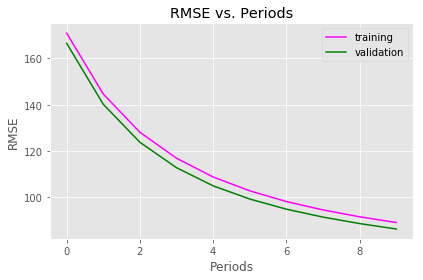

In [11]:
_ = train_model(
    learning_rate = 1.0,
    steps = 500,
    batch_size = 100,
    feature_columns = construct_bucketized_feature_columns(),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

### Train the model by Feature Cross

#### Crossing Latitude and Longitude

In [12]:
def feature_cross_bucketized_feature_columns():
    latitude = tf.feature_column.numeric_column("latitude")
    longitude = tf.feature_column.numeric_column("longitude")
    households = tf.feature_column.numeric_column("households")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_qunatile_based_boundaries(
            training_examples["latitude"], 10))
    
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_qunatile_based_boundaries(
            training_examples["longitude"], 10))
    
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_qunatile_based_boundaries(
            training_examples["households"], 7))
    
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_qunatile_based_boundaries(
            training_examples["housing_median_age"], 7))
    
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_qunatile_based_boundaries(
            training_examples["median_income"], 7))
    
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_qunatile_based_boundaries(
            training_examples["rooms_per_person"], 7))
    
    # Define a feature cross by longitude and latitude
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
    
    # Define feature_columns
    feature_columns = set([
        bucketized_latitude,
        bucketized_longitude,
        bucketized_households,
        bucketized_housing_median_age,
        bucketized_median_income,
        bucketized_rooms_per_person,
        long_x_lat
    ])
    return feature_columns

Training model...
  RMSE (on training data): 
    Period 01 : 164.92	160.57
    Period 02 : 136.74	132.39
    Period 03 : 119.67	115.53
    Period 04 : 108.33	104.54
    Period 05 : 100.31	96.85
    Period 06 : 94.19	91.09
    Period 07 : 89.68	86.86
    Period 08 : 86.13	83.49
    Period 09 : 83.23	80.73
    Period 10 : 80.88	78.51
Model training finished.


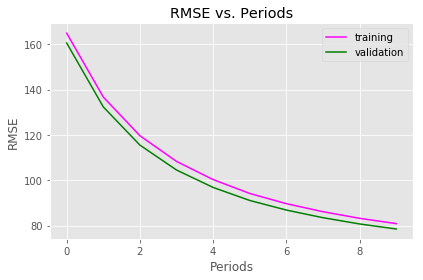

In [13]:
_ = train_model(
    learning_rate = 1.0,
    steps = 500,
    batch_size = 100,
    feature_columns = feature_cross_bucketized_feature_columns(),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)